## Stuttered image analysis

Craig Lage 10-May-22

HyeYun Park added for centroid x,y, elipticity analysis FEB-15-2023

In [13]:
%matplotlib inline
import sys, time, os, asyncio, glob
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.time import Time, TimeDelta
from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5, SkyCoord
import astropy.units as u
from lsst.obs.lsst.translators.latiss import AUXTEL_LOCATION
from lsst.daf.butler import Butler
import lsst.afw.detection as afwDetect
import lsst.afw.math as afwMath
from astropy.io import fits
from lsst.ip.isr.isrTask import IsrTask
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask, CharacterizeImageConfig
import lsst.summit.utils.butlerUtils as butlerUtils
from lsst.summit.utils.utils import detectSources
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
#butler = Butler('/repo/main', collections="LATISS/raw/all")
#butler = Butler('/repo/embargo', collections="LATISS/raw/all")
butler = butlerUtils.makeDefaultLatissButler(embargo=True)
#butler = Butler('/sdf/group/rubin/repo/main', collections="LATISS/raw/all")

In [8]:
isrConfig = IsrTask.ConfigClass()
isrConfig.doLinearize = False
isrConfig.doBias = True
isrConfig.doFlat = False
isrConfig.doDark = False
isrConfig.doFringe = False
isrConfig.doDefect = True
isrConfig.doWrite = False
isrConfig.doSaturation = False
isrConfig.doNanInterpolation = False
isrConfig.doNanMasking = False
isrConfig.doSaturation = False
isrConfig.doSaturationInterpolation = False
isrConfig.doWidenSaturationTrails = False

isrTask = IsrTask(config=isrConfig)

In [9]:
# Now get the image data and the metadata

expId = 2022101200490#70 #2022050400227 #2022050500692
raw = butler.get('raw', detector=0, exposure=expId)
bias=butler.get('bias',detector=0,exposure=expId)
defects=butler.get('defects',detector=0,exposure=expId)

exp=isrTask.run(raw, bias=bias, defects=defects).exposure

mData = exp.getMetadata()
date_beg = Time(mData['DATE-BEG'], format='isot', scale='tai')
time = date_beg.utc
print(expId, time)

2022101200490 2022-10-13T00:08:14.038


In [10]:
plt.figure(figsize=(8,8))
arr = exp.image.array#[0:2000,2500:2750]
img = plt.imshow(arr, norm=LogNorm(vmin=10000, vmax=25000),  interpolation='Nearest', cmap='gray')

plt.figure(figsize=(12,8))
plt.subplot(1,3,1)
plt.imshow(arr[0:2000,1050:1150], norm=LogNorm(vmin=10000, vmax=25000))
plt.subplot(1,3,2)
plt.imshow(arr[0:2000,3200:3300],norm=LogNorm(vmin=10000, vmax=25000))
plt.subplot(1,3,3)
plt.imshow(arr[0:2000,1050:3300],norm=LogNorm(vmin=10000, vmax=25000))


In [11]:
# Manually find a good bounding box
shift = 50
xmin = 2655
yfirst = 1995
yfinish = yfirst - 38 * shift
ystart = yfinish - shift
bgfirst = 1960
bgwidth = 30
bgstart = bgfirst - 38 * shift
bgfinish = bgstart + bgwidth
bgxmin = 2550
bgxmax = 3000


plt.figure(figsize=(4,4))
arr = exp.image.array[ystart:yfinish, xmin:xmin+shift]
bg = exp.image.array[bgstart:bgfinish, bgxmin:bgxmax]
background = np.nanmedian(bg)
print(f"Background = {background}")
arr = arr - background
print(f"Min = {arr.min()}, Max = {arr.max()}")
arr = np.clip(arr, 0.1, 200000)

img = plt.imshow(arr,   interpolation='Nearest', cmap='gray')
plt.colorbar()

Background = 16.327800750732422
Min = -40.82645797729492, Max = 28.818180084228516


In [10]:
#isrConfig = IsrTask.ConfigClass()
#isrConfig.doLinearize = False
#isrConfig.doBias = False #True
#isrConfig.doFlat = False 
#isrConfig.doDark = False
#isrConfig.doFringe = False
#isrConfig.doDefect = False
#isrConfig.doWrite = False
#isrConfig.doApplyGains = True

#isrTask = IsrTask(config=isrConfig)

In [3]:
isrConfig = IsrTask.ConfigClass()
isrConfig.doLinearize = False
isrConfig.doBias = True
isrConfig.doFlat = False
isrConfig.doDark = False
isrConfig.doFringe = False
isrConfig.doDefect = True
isrConfig.doWrite = False
isrConfig.doSaturation = False
isrConfig.doNanInterpolation = False
isrConfig.doNanMasking = False
isrConfig.doSaturation = False
isrConfig.doSaturationInterpolation = False
isrConfig.doWidenSaturationTrails = False

isrTask = IsrTask(config=isrConfig)

In [14]:
seqnum_array=np.arange(490,495,1)

In [15]:
repo_path="/repo/embargo" #"/sdf/group/rubin/repo/main/"
collections = 'LATISS/raw/all,LATISS/calib'.split(",")
butler = Butler(repo_path,collections=collections)
registry = butler.registry
kwargs={
"datasetType": "raw",
"collections": collections,
"where":
"""
instrument='LATISS' and 
detector=0 and
exposure.day_obs=20221012
"""
}
#'13241', '13161'
#instrument='LSST-TS8' and
#exposure.science_program in ( '7117D', '7118D', '7119D' )
datasetRefs = list(registry.queryDatasets(**kwargs))
print( f"You have {len(datasetRefs)} in this repository with the condition supplied {kwargs}")

You have 1235 in this repository with the condition supplied {'datasetType': 'raw', 'collections': ['LATISS/raw/all', 'LATISS/calib'], 'where': "\ninstrument='LATISS' and \ndetector=0 and\nexposure.day_obs=20221012\n"}


In [34]:
class sttrdImg():
    """Analysis class for stuttered images taken at AuxTel."""
    def __init__(self, dataId, shift=50):
        #obsdate = int(str(expId)[:8])
        #seq_num = int(str(expId)[8:])
        
        self.dataId = dataId #{'day_obs': obsdate, 'seq_num': seq_num, 'detector': 0}
        self.exp = self.runIsr()
        
        self.allSources = self.runDetect()
        
        self.shift = 50
        self.pixels = self.exp.image.array.shape
        self.mid = int(self.pixels[0] / 2)
        
        self.cat1, self.cat2 = self.getSpotCat()
        
    def runIsr(self):
        isrConfig = IsrTask.ConfigClass()
        isrConfig.doLinearize = False
        isrConfig.doBias = True
        isrConfig.doFlat = False
        isrConfig.doDark = False
        isrConfig.doFringe = False
        isrConfig.doDefect = True
        isrConfig.doWrite = False
        isrConfig.doSaturation = False
        isrConfig.doNanInterpolation = False
        isrConfig.doNanMasking = False
        isrConfig.doSaturation = False
        isrConfig.doSaturationInterpolation = False
        isrConfig.doWidenSaturationTrails = False
        
        isrTask = IsrTask(config=isrConfig)

        raw = butler.get('raw', self.dataId)
        bias = butler.get('bias', self.dataId)
        defects = butler.get('defects', self.dataId)
        exp = isrTask.run(raw, bias=bias, defects=defects).exposure
        return exp
    
    def runDetect(self):
        sources = detectSources(self.exp.image.array, self.exp.variance.array)
        return sources
    
    def getSpotCat(self):
        fluxes = np.array([src.flux for src in self.allSources])
        x = np.array([src.x for src in self.allSources])
        y=np.array([src.y for src in self.allSources])
        sort=np.argsort(fluxes)[::-1][:80]
        sorting_x=np.argsort(x[sort])[::-1]
        x_in_order=x[sort][sorting_x]
        y_following=y[sort][sorting_x]
        
        group1=np.where(abs(x_in_order-np.median(x_in_order[0:40]))<10)
        group2=np.where(abs(x_in_order-np.median(x_in_order[40:80]))<10)

        y_order_1=np.argsort(y_following[group1])[::-1]
        y_order_2=np.argsort(y_following[group2])[::-1]
        
        if len(np.array(group1)[0])<len(np.array(group2)[0]):
            larger_len=len(np.array(group2)[0])
            smaller_len=len(np.array(group1)[0])
        else: 
            larger_len=len(np.array(group1)[0])
            smaller_len=len(np.array(group2)[0])

        x_following1=x_in_order[group1][y_order_1][:smaller_len]
        x_following2=x_in_order[group2][y_order_2][:smaller_len]
        y_group1=y_following[group1][y_order_1][:smaller_len]
        y_group2=y_following[group2][y_order_2][:smaller_len]
        
        flux_1=fluxes[sort][sorting_x][group1][y_order_1][:smaller_len]
        flux_2=fluxes[sort][sorting_x][group2][y_order_2][:smaller_len]
        
        cat1=pd.DataFrame(data=np.array([x_following1,y_group1,flux_1]).T, columns=['x','y','flux'])
        cat2=pd.DataFrame(data=np.array([x_following2,y_group2,flux_2]).T, columns=['x','y','flux'])
  
        return cat1, cat2
        

    
    def display(self, ax, sources=False):
        ax.imshow(np.arcsinh(10*self.exp.image.array)/10, cmap="magma", origin="lower")
        if sources:
            [ax.plot(src.x, src.y, 'wx') for src in self.allSources]
            ax.plot(self.cat1['x'], self.cat1['y'], 'rx')
            ax.plot(self.cat2['x'], self.cat2['y'], 'bx')

In [48]:
seqnum_array=np.arange(487,491,1)
cat1_array_x,cat2_array_x=[],[]
cat1_array_y,cat2_array_y=[],[]
cat1_array_f,cat2_array_f=[],[]
for seqnum in seqnum_array:
    dataId = {'day_obs': 20221012, 'seq_num': int(seqnum), 'detector': 0, "instrument": 'LATISS'}
    img = sttrdImg(dataId)
    
    cat1_array_x=np.append(cat1_array_x,img.cat1['x'])
    cat1_array_y=np.append(cat1_array_y,img.cat1['y'])
    cat1_array_f=np.append(cat1_array_f,img.cat1['flux'])
    cat2_array_x=np.append(cat2_array_x,img.cat2['x'])
    cat2_array_y=np.append(cat2_array_y,img.cat2['y'])
    cat2_array_f=np.append(cat2_array_f,img.cat2['flux'])
cat1_array=pd.DataFrame(data=np.array([cat1_array_x,cat1_array_y,cat1_array_f]).T, columns=['x','y','flux'])
cat2_array=pd.DataFrame(data=np.array([cat2_array_x,cat2_array_y,cat2_array_f]).T, columns=['x','y','flux'])

/home/h/hyeyun/repos/summit_utils/python/lsst/summit/utils/utils.py:654: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.nanmedian(np.sqrt(variance))


In [ ]:
print (cat1_array.shape)
print (img.cat1.shape)

(38, 3)
(2, 3)


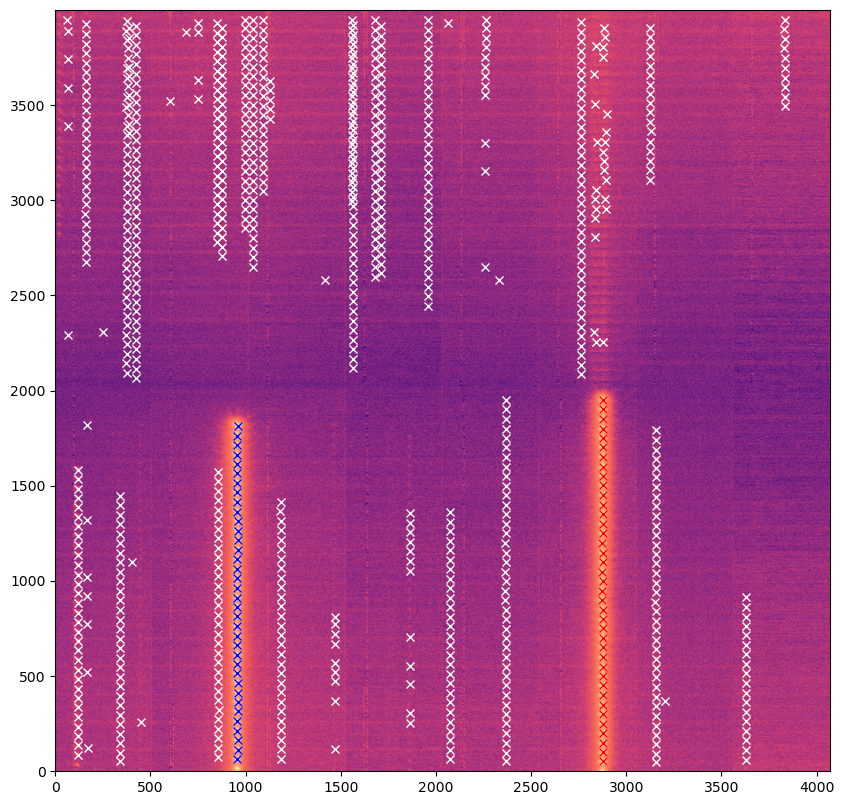

In [21]:
f, ax = plt.subplots(1,1, figsize=(10,10))
img.display(ax, sources=True)
plt.show()

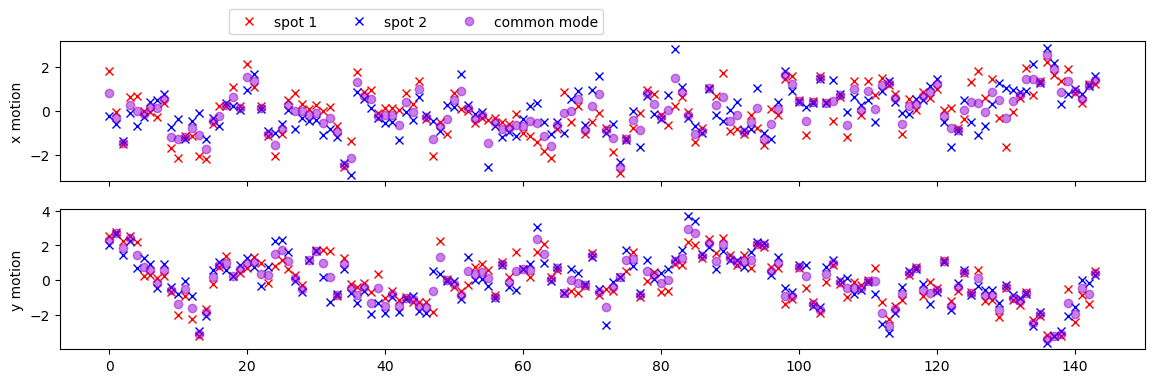

In [79]:
f, a = plt.subplots(2,1, figsize=(14,4), sharex=True)

for cat, color, label in zip([cat1_array, cat2_array], ['r', 'b'], ['spot 1', 'spot 2']):
    shift_index_array=np.tile(cat.index[:len(cat.index)//len(seqnum_array)],len(seqnum_array))
    y_to_plot = cat['y']+ shift_index_array*img.shift
    a[0].plot(cat.index, cat['x'] - cat['x'].mean(), 'x', color=color, label=label)
    a[1].plot(cat.index, y_to_plot- y_to_plot.mean(), 'x', color=color)

common_x = (cat1_array['x'] + cat2_array['x']) / 2
common_y = (cat1_array['y'] + cat2_array['y']) / 2  + shift_index_array*img.shift #cat1_array.index*img.shift

a[0].plot(cat1_array.index, common_x - common_x.mean(), 'o', color='darkviolet', label='common mode', alpha=0.5)
a[1].plot(cat1_array.index, common_y - common_y.mean(), 'o', color='darkviolet', alpha=0.5)
a[0].legend(ncol=3, bbox_to_anchor=(0.15,1))
a[0].set_ylabel('x motion')
a[1].set_ylabel('y motion')

plt.show()

In [ ]:
f, a = plt.subplots(1,3, figsize=(9,7), sharex=True)
a[2].plot(x_following1-np.mean(x_following1),index[0:len(np.array(group1)[0])]+1,'x',color='b',label='group1')
a[2].set_ylim(larger_len+1,0)
a[2].set_yticks(np.arange(larger_len)+np.ones(larger_len))
a[2].grid(True)


a[1].plot(common_x - common_x.mean(),index[0:len(common_x)]+1,  'o', color='darkviolet', label='common mode', alpha=0.5)
a[1].set_ylim(larger_len+1,0)
a[1].set_yticks(np.arange(larger_len)+np.ones(larger_len))
a[1].grid(True)

a[0].plot(x_following2-np.mean(x_following2),index[0:len(np.array(group2)[0])]+1,'x',color='g',label='group2')
a[0].set_ylim(larger_len+1,0)
a[0].set_yticks(np.arange(larger_len)+np.ones(larger_len))
a[0].grid(True)

In [ ]:
dataId = {'day_obs': 20221012, 'seq_num': 490, 'detector': 0, "instrument": 'LATISS'}
raw = butler.get('raw', dataId)
bias = butler.get('bias', dataId)
defects = butler.get('defects', dataId)
exp = isrTask.run(raw, bias=bias, defects=defects).exposure

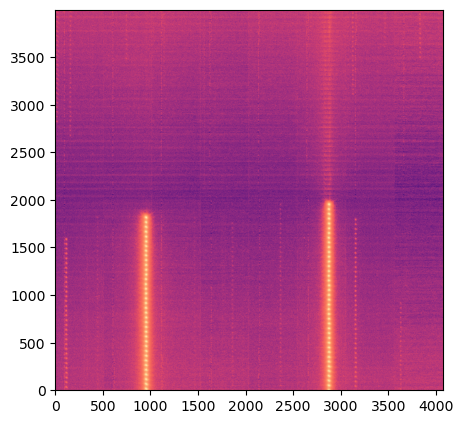

In [ ]:
fig,ax= plt.subplots(1,1, figsize=(5,5))
img = ax.imshow(np.arcsinh(10*exp.image.array)/10, cmap="magma", origin="lower")

In [ ]:
charConfig = CharacterizeImageConfig()
charConfig.installSimplePsf.fwhm = 0.1
charConfig.doMeasurePsf = False
charConfig.doApCorr = False
charConfig.doDeblend = False
charConfig.repair.doCosmicRay = False #True
charConfig.repair.cosmicray.nCrPixelMax=1000000
charConfig.repair.doInterpolate = False   
charConfig.detection.background.binSize = 32 #2 #5 #10 #10#15#32
charConfig.detection.minPixels = 3#5#10
charTask = CharacterizeImageTask(config=charConfig)

In [ ]:
sources = detectSources(exp.image.array, exp.variance.array)

In [ ]:
def getSpotCat(self):
    fluxes = np.array([src.flux for src in self.allSources])
    x = np.array([src.x for src in self.allSources])

    # find the series of spots for 2 brightest sources
    max_1 = np.argmax(fluxes)
    x_max = x[max_1]
    spot_1 = np.where(abs(x - x_max) < 10)

    flux_max = fluxes[spot_1]
    fluxes[spot_1] = 0
    max_2 = np.argmax(fluxes)
    fluxes[spot_1] = flux_max

    x_max = x[max_2]
    spot_2 = np.where(abs(x - x_max) < 10)

    cat1 = self.makeSingleCat(spot_1)
    cat2 = self.makeSingleCat(spot_2)

    return cat1, cat2

In [ ]:
fluxes = np.array([src.flux for src in sources])
x = np.array([src.x for src in sources])
y=np.array([src.y for src in sources])

In [ ]:
sort=np.argsort(fluxes)[::-1][:80]
sorting_x=np.argsort(x[sort])[::-1]
x_in_order=x[sort][sorting_x]
y_following=y[sort][sorting_x]
#print(x_in_order)
#print(np.median(x_in_order[0:40]))
#print(np.median(x_in_order[40:80]))
group1=np.where(abs(x_in_order-np.median(x_in_order[0:40]))<10)
group2=np.where(abs(x_in_order-np.median(x_in_order[40:80]))<10)
#print (x[sort],fluxes[sort])

In [ ]:
y_order_1=np.argsort(y_following[group1])[::-1]
y_order_2=np.argsort(y_following[group2])[::-1]

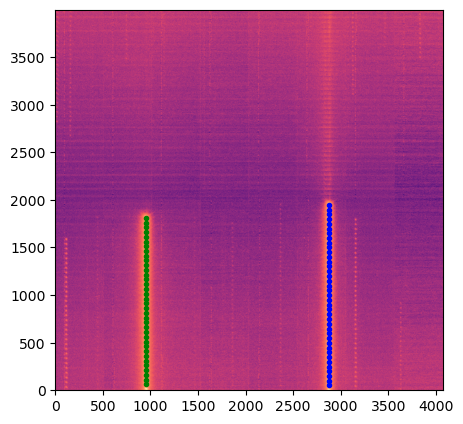

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(np.arcsinh(10*exp.image.array)/10, cmap="magma", origin="lower")
plt.plot(x_in_order[group1][y_order_1], y_following[group1][y_order_1], "b.")
plt.plot(x_in_order[group2][y_order_2], y_following[group2][y_order_2], "g.")

plt.show()

In [ ]:
print(len(np.array(group1)[0]),len(np.array(group2)[0]))
if len(np.array(group1)[0])<len(np.array(group2)[0]):
    larger_len=len(np.array(group2)[0])
    smaller_len=len(np.array(group1)[0])
else: 
    larger_len=len(np.array(group1)[0])
    smaller_len=len(np.array(group2)[0])

39 36


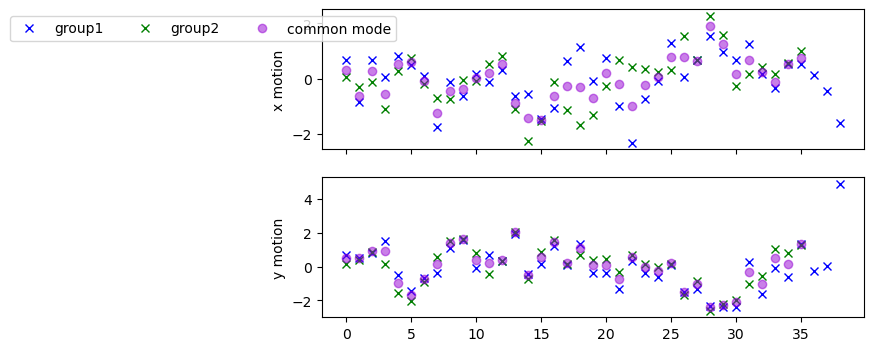

In [ ]:
f, a = plt.subplots(2,1, figsize=(7,4), sharex=True)
index=np.linspace(0,larger_len-1, larger_len)
shift=50

x_following1=x_in_order[group1][y_order_1]
x_following2=x_in_order[group2][y_order_2]
y_group1=y_following[group1][y_order_1]
y_group2=y_following[group2][y_order_2]

a[0].plot(index[:len(np.array(group1)[0])],x_following1-np.mean(x_following1),'x',color='b',label='group1')
a[0].plot(index[:len(np.array(group2)[0])],x_following2-np.mean(x_following2),'x',color='g',label='group2')
                  
a[1].plot(index[:len(np.array(group1)[0])],y_group1 + index[:len(np.array(group1)[0])]*shift-np.mean(y_group1+ index[:len(np.array(group1)[0])]*shift),'x',color='b',label='group1')
a[1].plot(index[:len(np.array(group2)[0])],y_group2 + index[:len(np.array(group2)[0])]*shift-np.mean(y_group2+ index[:len(np.array(group2)[0])]*shift),'x',color='g',label='group2')
  
common_x = (x_following1[:smaller_len] + x_following2[:smaller_len]) / 2
common_y = (y_group1[:smaller_len] + y_group2[:smaller_len]) / 2  +index[:smaller_len]*shift

a[0].plot(index[:len(common_x)], common_x - common_x.mean(), 'o', color='darkviolet', label='common mode', alpha=0.5)
a[1].plot(index[:len(common_x)], common_y - common_y.mean(), 'o', color='darkviolet', alpha=0.5)

a[0].legend(ncol=3, bbox_to_anchor=(0.15,1))
a[0].set_ylabel('x motion')
a[1].set_ylabel('y motion')

plt.show()

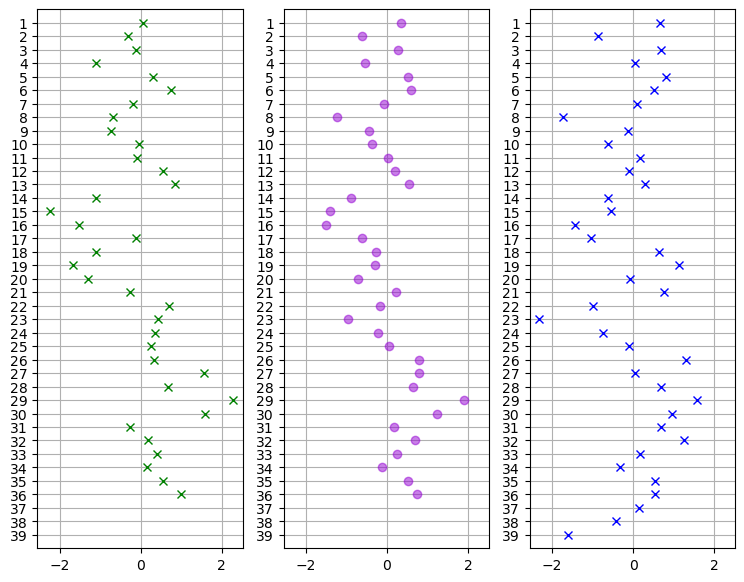

In [126]:
f, a = plt.subplots(1,3, figsize=(9,7), sharex=True)
a[2].plot(x_following1-np.mean(x_following1),index[0:len(np.array(group1)[0])]+1,'x',color='b',label='group1')
a[2].set_ylim(larger_len+1,0)
a[2].set_yticks(np.arange(larger_len)+np.ones(larger_len))
a[2].grid(True)


a[1].plot(common_x - common_x.mean(),index[0:len(common_x)]+1,  'o', color='darkviolet', label='common mode', alpha=0.5)
a[1].set_ylim(larger_len+1,0)
a[1].set_yticks(np.arange(larger_len)+np.ones(larger_len))
a[1].grid(True)

a[0].plot(x_following2-np.mean(x_following2),index[0:len(np.array(group2)[0])]+1,'x',color='g',label='group2')
a[0].set_ylim(larger_len+1,0)
a[0].set_yticks(np.arange(larger_len)+np.ones(larger_len))
a[0].grid(True)

In [131]:
def detectObjectsInExp(exp, nSigma=10, nPixMin=10, grow=0):
    """Return the footPrintSet for the objects in a postISR exposure."""
    median = np.nanmedian(exp.image.array)
    exp.image -= median

    threshold = afwDetect.Threshold(nSigma, afwDetect.Threshold.STDEV)
    footPrintSet = afwDetect.FootprintSet(exp.getMaskedImage(), threshold, "DETECTED", nPixMin)
    if grow > 0:
        isotropic = True
        footPrintSet = afwDetect.FootprintSet(footPrintSet, grow, isotropic)

    exp.image += median  # add back in to leave background unchanged
    return footPrintSet

In [ ]:
spotCatalog[0]

In [134]:
seqnum=490 #470
dataId={'day_obs': 20221012, 'seq_num': seqnum, 'detector': 0}
raw = butler.get('raw', dataId)
postIsr = isrTask.run(raw).exposure
charResult = charTask.run(postIsr)
spotCatalog = charResult.sourceCat

xx=spotCatalog['ext_shapeHSM_HsmSourceMoments_xx']#base_SdssShape_xx']
yy=spotCatalog['ext_shapeHSM_HsmSourceMoments_yy']#base_SdssShape_yy']
xy=spotCatalog['ext_shapeHSM_HsmSourceMoments_xy']#base_SdssShape_xy']
x=spotCatalog['base_SdssCentroid_x']
y=spotCatalog['base_SdssCentroid_y']

#x=spotCatalog['ext_shapeHSM_HsmSourceMoments_x']#base_SdssCentroid_x']
#y=spotCatalog['ext_shapeHSM_HsmSourceMoments_y']#base_SdssCentroid_y']
#area=spotCatalog['base_FootprintArea_value']
#psfXX=spotCatalog['base_SdssShape_psf_xx']
#psfYY=spotCatalog['base_SdssShape_psf_yy']
#psfXY=spotCatalog['base_SdssShape_psf_xy']
size=np.power(xx*yy-xy**2,0.25)
#size=np.power(psfXX*psfYY-psfXY**2,0.25)
norm = plt.Normalize(np.nanmin(size), vmax=np.nanmax(size))#vmin=1., vmax=2.2) #np.nanmin(size), vmax=np.nanmax(size))


In [ ]:
xsample=[1,2,3]
ysample=[1,2,4]
csample=['red','blue','green']
print (np.arange(len(xsample)))
for i in np.arange(len(xsample)):
    if i==len(xsample)-1:
        print ("hit the limit")
    else:
        print (i)
        plt.arrow(xsample[i],ysample[i],xsample[i+1]-xsample[i],ysample[i+1]-ysample[i],color=csample[i],width=0.02)

In [29]:
xx=spotCatalog['base_SdssShape_xx']
yy=spotCatalog['base_SdssShape_yy']
xy=spotCatalog['base_SdssShape_xy']
x1min, x1max=2050,2100
xxinrange1=xx[np.where(np.logical_and(x>=x1min, x<=x1max))]
yyinrange1=yy[np.where(np.logical_and(x>=x1min, x<=x1max))]
xyinrange1=xy[np.where(np.logical_and(x>=x1min, x<=x1max))]

print ("1st", len(xinrange1), ", 2nd ", len(xinrange2))
print("x        |y        |size  |xx    |yy    |xy")
for i in range(len(xinrange1)):
    print("%.4f|%.4f|%.4f|%.4f|%.4f|%.4f"%(xinrange1[i],yinrange1[i],sizeinrange1[i],xxinrange1[i],yyinrange1[i],xyinrange1[i]))

KeyError: "Field with name 'base_SdssShape_xx' not found"

In [176]:
xx=spotCatalog['base_SdssShape_xx']
yy=spotCatalog['base_SdssShape_yy']
xy=spotCatalog['base_SdssShape_xy']
from lsst.validate.drp.util import ellipticity
ell=ellipticity(xx,xy,yy)

xxinrange=xx[np.where(np.logical_and(x>=2759.9, x<=2760.1))]
yyinrange=yy[np.where(np.logical_and(x>=2759.9, x<=2760.1))]
xyinrange=xy[np.where(np.logical_and(x>=2759.9, x<=2760.1))]

#print (np.nanmin(ell[2]),np.nanmax(ell[2]))
xs = spotCatalog['base_SdssCentroid_x']
ys = spotCatalog['base_SdssCentroid_y']
xsinrange=xs[np.where(np.logical_and(x>=2759.9, x<=2760.1))]
ysinrange=ys[np.where(np.logical_and(x>=2759.9, x<=2760.1))]

plt.figure(figsize=(8,8))    
plt.subplot(1,3,1,aspect=1)
plt.title('ellipticities on each spot')
plt.ylim(2000,4100)
plt.xlim(2700,2800)
e = np.abs(ell[0][np.where(np.logical_and(x>=2759.9, x<=2760.1))]) #(ell[0]+0.5)/np.nanmax(ell[0]) * 100.0
norm = plt.Normalize(vmin=-1.0, vmax=1.0)

plt.scatter(xsinrange,ysinrange,c=e, norm=None, cmap=plt.cm.jet, s=5)
plt.colorbar()
plt.subplot(1,3,2,aspect=1)
plt.title('e1 on each spot')
e1 = ell[1][np.where(np.logical_and(x>=2759.9, x<=2760.1))] #(ell[0]+0.5)/np.nanmax(ell[0]) * 100.0
plt.scatter(xsinrange,ysinrange,c=e1, norm=None, cmap=plt.cm.jet, s=5)
plt.ylim(2000,4100)
plt.xlim(2700,2800)
plt.colorbar()


plt.subplot(1,3,3,aspect=1)
plt.title('e2 on each spot')
e2 = ell[2][np.where(np.logical_and(x>=2759.9, x<=2760.1))] #(ell[0]+0.5)/np.nanmax(ell[0]) * 100.0
plt.scatter(xsinrange,ysinrange,c=e2, norm=None, cmap=plt.cm.jet, s=5)
plt.ylim(2000,4100)
plt.xlim(2700,2800)
plt.colorbar()


ModuleNotFoundError: No module named 'lsst.validate'

In [72]:
print("x        |y        |size  |xx    |yy    |xy    |e     |e1    |e2")
for i in range(len(xinrange)):
    print("%.4f|%.4f|%.4f|%.4f|%.4f|%.4f|%.4f|%.4f|%.4f"%(xinrange[i],yinrange[i],sizeinrange[i],xxinrange[i],yyinrange[i],xyinrange[i],e[i],e1[i],e2[i]))

x        |y        |size  |xx    |yy    |xy    |e     |e1    |e2
2759.9762|2084.9985|0.3549|0.1260|0.1258|0.0000|0.0007|0.0007|0.0003
2759.9771|2134.9972|0.3548|0.1260|0.1258|0.0001|0.0008|0.0006|0.0005
2759.9821|2185.0060|0.3548|0.1259|0.1258|-0.0001|0.0009|0.0004|-0.0008
2759.9814|2235.0007|0.3548|0.1259|0.1258|-0.0000|0.0004|0.0004|-0.0001
2759.9782|2285.0023|0.3548|0.1260|0.1258|-0.0000|0.0007|0.0006|-0.0004
2759.9805|2334.9996|0.3548|0.1260|0.1258|0.0000|0.0005|0.0005|0.0001
2759.9761|2385.0014|0.3549|0.1260|0.1258|-0.0000|0.0007|0.0007|-0.0003
2759.9718|2435.0069|0.3549|0.1261|0.1258|-0.0002|0.0018|0.0009|-0.0015
2759.9939|2485.0011|0.3548|0.1259|0.1258|-0.0000|0.0001|0.0000|-0.0000
2759.9730|2535.0061|0.3549|0.1260|0.1258|-0.0002|0.0016|0.0008|-0.0013
2759.9752|2584.9932|0.3549|0.1260|0.1258|0.0002|0.0015|0.0007|0.0014
2759.9801|2635.0020|0.3548|0.1260|0.1258|-0.0000|0.0006|0.0005|-0.0003
2759.9864|2685.0051|0.3548|0.1259|0.1258|-0.0001|0.0006|0.0002|-0.0006
2759.9777|2734.9991|